In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da
from geopy.distance import geodesic

In [2]:
trackdat = "../data/track_data/HERMINE_2016"
df = pd.read_csv(trackdat, skiprows=1)

In [3]:
hermlen = len(df[df.columns[0]])

In [4]:
hurrnum = np.ones(hermlen)
for i in range(hermlen):
    yearmoda = str(df[df.columns[0]][i])
    hours    = int(df[df.columns[1]][i]/100)
    dateform = datetime.datetime(int(yearmoda[:4]), int(yearmoda[4:6]), int(yearmoda[6:]), hours)
    hurrnum[i] = mdates.date2num(dateform)

In [5]:
latsN, lonsN = df.columns[4], df.columns[5]

hurrlats = [float(df[latsN][i][:-1]) for i in range(len(df[df.columns[0]]))]
hurrlons = [-float(df[lonsN][i][:-1]) for i in range(len(df[df.columns[0]]))]

In [6]:
dataloc = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/all/ru30-20160901T1316.ncCFMA.nc3.nc"

In [7]:
df = xr.open_dataset(dataloc, decode_times=False)

In [8]:
df

<xarray.Dataset>
Dimensions:          (obs: 460, profile: 2105, trajectory: 1)
Coordinates:
  * trajectory       (trajectory) |S64 b'ru30-20160901T1316'
    time             (trajectory, profile) float64 ...
    latitude         (trajectory, profile) float64 ...
    longitude        (trajectory, profile) float64 ...
    time_uv          (trajectory, profile) float64 ...
    lat_uv           (trajectory, profile) float64 ...
    lon_uv           (trajectory, profile) float64 ...
    depth            (trajectory, profile, obs) float32 ...
Dimensions without coordinates: obs, profile
Data variables:
    wmo_id           (trajectory) |S64 ...
    profile_id       (trajectory, profile) float32 ...
    u                (trajectory, profile) float64 ...
    v                (trajectory, profile) float64 ...
    precise_time     (trajectory, profile, obs) float64 ...
    pressure         (trajectory, profile, obs) float32 ...
    temperature      (trajectory, profile, obs) float32 ...
    conductivity     (trajectory, profile, obs) float32 ...
    salinity         (trajectory, profile, obs) float32 ...
    density          (trajectory, profile, obs) float32 ...
    precise_lat      (trajectory, profile, obs) float64 ...
    precise_lon      (trajectory, profile, obs) float64 ...
    platform_meta    (trajectory, profile, obs) float32 ...
    instrument_ctd   (trajectory, profile, obs) float32 ...
    precise_time_qc  (trajectory, profile, obs) float32 ...
    depth_qc         (trajectory, profile, obs) float32 ...
    pressure_qc      (trajectory, profile, obs) float32 ...
    temperature_qc   (trajectory, profile, obs) float32 ...
    conductivity_qc  (trajectory, profile, obs) float32 ...
    salinity_qc      (trajectory, profile, obs) float32 ...
    density_qc       (trajectory, profile, obs) float32 ...
    precise_lat_qc   (trajectory, profile, obs) float32 ...
    precise_lon_qc   (trajectory, profile, obs) float32 ...
    time_qc          (trajectory, profile, obs) float32 ...
    latitude_qc      (trajectory, profile, obs) float32 ...
    longitude_qc     (trajectory, profile, obs) float32 ...
    time_uv_qc       (trajectory, profile, obs) float32 ...
    lat_uv_qc        (trajectory, profile, obs) float32 ...
    lon_uv_qc        (trajectory, profile, obs) float32 ...
    u_qc             (trajectory, profile, obs) float32 ...
    v_qc             (trajectory, profile, obs) float32 ...
Attributes:
    acknowledgment:                This deployment supported by NOAA through ...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Glider operated by the Rutgers University ...
    contributor_name:              Scott Glenn, Oscar Schofield, Josh Kohut, ...
    contributor_role:              Principal Investigator, Principal Investig...
    Conventions:                   Unidata Dataset Discovery v1.0, COARDS, CF...
    creator_email:                 kerfoot@marine.rutgers.edu
    creator_name:                  John Kerfoot
    creator_url:                   http://rucool.marine.rutgers.edu
    date_created:                  2016-09-26T13:36:32Z
    date_issued:                   2016-09-26T13:36:32Z
    defaultGraphQuery:             longitude,latitude,time&.draw=linesAndMark...
    Easternmost_Easting:           -73.1918623991848
    featureType:                   TrajectoryProfile
    format_version:                /tmp/IOOS_Glider_NetCDF_v2.0-qartod.nc
    geospatial_lat_max:            39.35681623025626
    geospatial_lat_min:            38.349612935876806
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -73.1918623991848
    geospatial_lon_min:            -74.32501886460227
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       116.47
    geospatial_vertical_min:       1.0
    geospatial_vertic

In [9]:
glats = np.squeeze(df.latitude.values)
glons = np.squeeze(df.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        glider_LL = (glatitude, glons[i])
        hurr_ll   = (hlatitude, hurrlons[j])
        distance_metric[i,j] = geodesic(glider_LL, hurr_ll).miles

In [22]:
b = np.amin(distance_metric)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrnum[ktime]
mdates.num2date(eyepassage)

datetime.datetime(2016, 9, 7, 6, 0, tzinfo=datetime.timezone.utc)

In [11]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
dlen    = np.shape(df.depth)[2]
for i, sec in enumerate(df.time.values[0,:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[0,i,:] = mdates.date2num(datetmp)*np.ones(dlen)

In [12]:
start = mdates.date2num(datetime.datetime(2016,9,5))
enddd = mdates.date2num(datetime.datetime(2016,9,8))

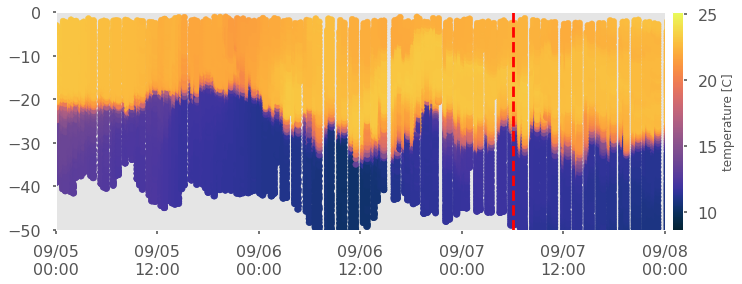

In [20]:
plt.figure(figsize=(13,4))
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.ylim([-50,0])
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

In [14]:
def discrete_to_grid(times_in,depth_in,variable,times_grid,depths_grid):
    from scipy.interpolate import interp1d
    N = len(times_in)
    time_array = times_grid[:,0]
    deptharray = depths_grid[0,:]
    var_out = np.ones_like(times_grid)
    # loop over index of input coordinates
    dT = 1/24/3
    for j, T in enumerate(time_array):
        # centre coordinates on estimation point
        a = times_in > T-dT
        b = times_in < T+dT
        q = np.logical_and(a,b)
        #q = np.where(times_in == T)
        dep = depth_in[q]
        var = variable[q]
        #print(np.shape(var))
        f = interp1d(dep,var,kind='linear')
        tmp = np.ones_like(deptharray)*np.nan
        q_less = np.where(deptharray<np.nanmax(dep))
        q_more = np.where(deptharray>np.nanmin(dep))
        q = np.intersect1d(q_more,q_less)
        dtmp = deptharray[q]
        tmp[q] = f(deptharray[q])
        var_out[j,:] = tmp    
    return var_out

In [15]:
times = datenum[0,:,0]
depth = np.arange(1,60,2)
DEPTH, TIMES = np.meshgrid(depth,times)

In [16]:
a = df.temperature[0,:,:].values.reshape(-1)
a.shape, TIMES.shape

((968300,), (2105, 30))

In [17]:
TEMPS = discrete_to_grid(datenum[0,:,:].reshape(-1), df.depth[0,:,:].values.reshape(-1), df.temperature[0,:,:].values.reshape(-1),TIMES, DEPTH)
DENSE = discrete_to_grid(datenum[0,:,:].reshape(-1), df.depth[0,:,:].values.reshape(-1), df.density[0,:,:].values.reshape(-1),TIMES, DEPTH)

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


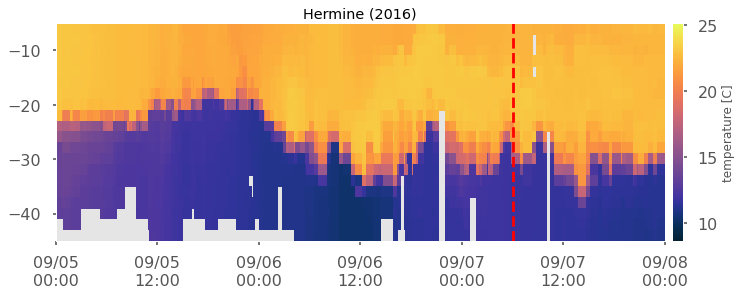

In [21]:
plt.figure(figsize=(13,4))
plt.pcolor(TIMES,-DEPTH,TEMPS, cmap='cmo.thermal')#, levels=np.linspace(8,26,19))
plt.colorbar(pad=0.01, label="temperature [C]")
plt.ylim([-45,-5])
plt.xlim([start, enddd])
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Hermine (2016)')
plt.savefig("FIGS/temperatures_Hermine2016.pdf", bbox_inches='tight')

In [19]:
st = mdates.date2num(datetime.datetime(2016,9,5))
en = mdates.date2num(datetime.datetime(2016,9,5,18))

a = times < en
b = times > st
q = np.logical_and(a,b)
temps_before = TEMPS[q,:]
temps_before = np.nanmean(temps_before, axis=(0))
#plt.plot(temps_before)

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


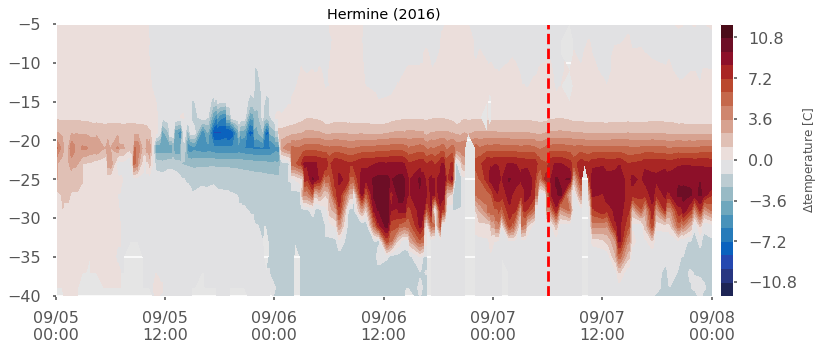

In [20]:
plt.figure(figsize=(14,5))
plt.contourf(TIMES,-DEPTH,TEMPS-temps_before[np.newaxis,:], cmap='cmo.balance', levels=np.linspace(-12,12,21))
plt.colorbar(pad=0.01, label="$\Delta$temperature [C]")
plt.ylim([-40,-5])
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.title('Hermine (2016)')
plt.savefig("FIGS/dT_Hermine2016.pdf", bbox_inches='tight')

In [21]:
b44065 = "../data/ndbc_years/44065h2016.txt"
b44009 = "../data/ndbc_years/44009h2016.txt"

In [42]:
ndb = pd.read_csv(b44065, skiprows=[1], delim_whitespace=True)
nd2 = pd.read_csv(b44009, skiprows=[1], delim_whitespace=True)

In [43]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

nd2_datenum = [mdates.date2num(datetime.datetime(nd2['#YY'][i],nd2['MM'][i],nd2['DD'][i],nd2['hh'][i],nd2['mm'][i])) 
               for i in range(len(nd2))]
nd2_datenum = np.asarray(nd2_datenum)

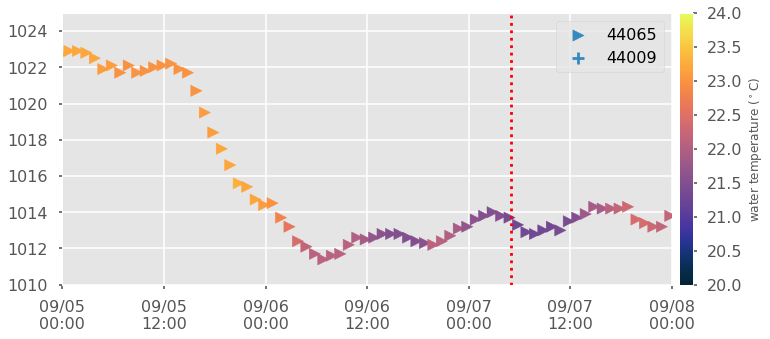

In [66]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['PRES'], c=ndb['WTMP'], vmin=20, vmax=24, cmap=cmo.thermal, marker=">", label="44065")
plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=20, vmax=24, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='water temperature ($^\circ$C)')
plt.xlim([start, enddd])
plt.legend()
plt.axvline(x = eyepassage-1/24, c='r', linestyle=":")
plt.ylim([1010,1025])
plt.gca().xaxis.set_major_formatter(myFmt)

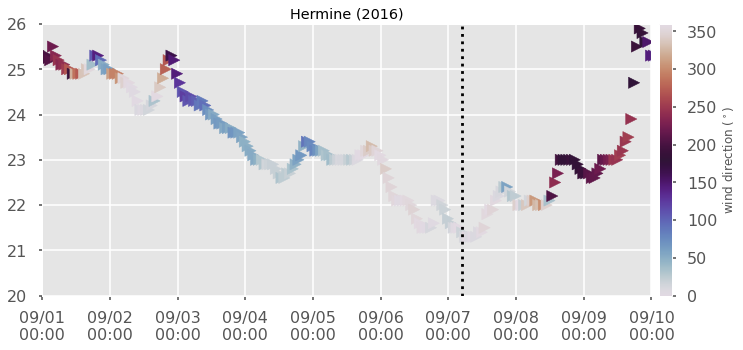

In [62]:
wtemp = ndb['WTMP'].values
wtemp[wtemp > 35] = np.nan

plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP'], marker=">", label="44065", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.scatter(nd2_datenum,nd2['WTMP'], marker="+", label="44009", c=nd2['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.axvline(x = eyepassage-1/24, c='k', linestyle=":")
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([start-4, enddd+2])
plt.ylim([20,26])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Hermine (2016)')
plt.savefig("FIGS/steadywinds_Hermine2016.pdf", bbox_inches='tight')